In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from topicpy.geneontology import get_symbol
import plotly.graph_objects as go
import cloudpickle as pickle
import multiprocessing as mp
from time import time
import logging
log = logging.getLogger("go_expression")

In [2]:
with open("A.pkl", "rb") as file:
    A = pickle.load(file)
A.head(2)

,abundance,Name,frequency
ensg,,,
ENSG00000223972,250.103187,DDX11L1,1.438863e-08
ENSG00000227232,72945.168960,WASH7P,4.196593e-06


In [ ]:
#GTEx
df_generator = pd.read_csv('../GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct', skiprows=2, sep='\t', chunksize=1000)

log.info("read generator")

A = pd.DataFrame(columns = ["ensg", "abundance"])

for subdf in df_generator:
    subdf['ensg'] = [x[:15] for x in subdf['Name']]
    subdf.drop(["Name", "Description"], axis=1, inplace=True)
    subdf["abundance"] = subdf.sum(axis=1)
    A = A.append(subdf.reindex(columns=["ensg", "abundance"]))
    log.debug("new chunk")

A.set_index("ensg", inplace=True)
  
A["Name"] = list(map(get_symbol, A.index))
A["frequency"] = A["abundance"]/A["abundance"].sum()
    
with open("A.pkl", "wb") as file:
    pickle.dump(A, file)
    
A.head(2)

In [3]:
df_go = pd.DataFrame()
with open("../MSigDB/c5.all.v7.1.symbols.gmt", "r") as gmt_file:
    for line in gmt_file.read().split("\n"):
        if len(line) < 1:
            break
        data = line.replace("\n","").split("\t")
        s = pd.Series(name = data[0], data = data[2:])
        df_go.insert(0,s.name,s)
df_go.head(2)

,GO_GAP_JUNCTION_CHANNEL_ACTIVITY_INVOLVED_IN_CELL_COMMUNICATION_BY_ELECTRICAL_COUPLING,GO_RNA_BINDING_INVOLVED_IN_POSTTRANSCRIPTIONAL_GENE_SILENCING,GO_IMMUNE_RECEPTOR_ACTIVITY,GO_FLOPPASE_ACTIVITY,GO_FLIPPASE_ACTIVITY,GO_ATPASE_COUPLED_INTRAMEMBRANE_LIPID_TRANSPORTER_ACTIVITY,GO_SOLUTE_ANION_ANTIPORTER_ACTIVITY,GO_CARGO_ADAPTOR_ACTIVITY,GO_INTRAMEMBRANE_LIPID_TRANSPORTER_ACTIVITY,GO_SMALL_MOLECULE_SENSOR_ACTIVITY,...,GO_POSITIVE_REGULATION_OF_KINASE_ACTIVITY,GO_POSITIVE_REGULATION_OF_EPITHELIAL_CELL_DIFFERENTIATION,GO_CELLULAR_RESPONSE_TO_LIPOPROTEIN_PARTICLE_STIMULUS,GO_PLATELET_DERIVED_GROWTH_FACTOR_RECEPTOR_SIGNALING_PATHWAY,GO_SPINAL_CORD_DEVELOPMENT,GO_PHOSPHATIDYLSERINE_ACYL_CHAIN_REMODELING,GO_CIRCADIAN_RHYTHM,GO_DNA_DEPENDENT_DNA_REPLICATION_MAINTENANCE_OF_FIDELITY,GO_CARDIAC_CHAMBER_DEVELOPMENT,GO_POSITIVE_REGULATION_OF_VIRAL_TRANSCRIPTION
0,GJC1,MIR675,KLRC4-KLRK1,ABCA7,TMEM30B,ABCA7,SLC26A1,TEX261,ABCA7,EGLN2,...,ABI1,CD24,CDH13,TXNIP,OLIG2,PLA2G4B,ADA,ALYREF,ZMPSTE24,CDK9
1,GJB6,MIR298,EBI3,ABCA1,ABCA4,TMEM30B,SLC22A9,AP2M1,ANO4,EFHB,...,CD24,CDH5,TLR6,RGS14,GDF11,LPCAT3,NR1H3,CDK9,UBE4B,CHD1


In [4]:
df_conversion = pd.read_csv("https://www.genenames.org/cgi-bin/download/custom?col=gd_hgnc_id&col=gd_app_sym&col=gd_pub_refseq_ids&col=gd_pub_ensembl_id&col=md_eg_id&col=md_ensembl_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit", sep="\t")
df_conversion.head(2)

,HGNC ID,Approved symbol,RefSeq IDs,Ensembl gene ID,NCBI Gene ID(supplied by NCBI),Ensembl ID(supplied by Ensembl)
0,HGNC:5,A1BG,NM_130786,ENSG00000121410,1.0,ENSG00000121410
1,HGNC:37133,A1BG-AS1,NR_015380,ENSG00000268895,503538.0,ENSG00000268895


In [5]:
gos = df_go.columns

In [6]:
def get_gene_abundances(genes: list)->np.array:
    return A[A["Name"].isin(genes)]["frequency"].values

def get_genes_in_go(go:str)->list:
    return df_go.loc[:,go].dropna()

def get_average_expression(go:str, thr = 40)->float:
    A = get_gene_abundances(get_genes_in_o(go))
    if len(A) > thr:
        return A.mean(), A.std()
    else:
        return np.nan
    
def get_expression(go:str, thr = 40)->float:
    A = get_gene_abundances(get_genes_in_go(go))
    if len(A) > thr:
        return get_gene_abundances(get_genes_in_go(go))
    else:
        return None    

def get_named_expression(go:str, thr = 40)->float:
    A = get_gene_abundances(get_genes_in_go(go))
    if len(A) > thr:
        return go, get_gene_abundances(get_genes_in_go(go))
    else:
        return None
    
def get_box(name:str, data: np.array)->go.Box:
    return go.Box(y=data, name=" ".join(name.split("_")[:3])+"<br>"+" ".join(name.split("_")[3:6]))

def get_nullable_box(data)->go.Box:
    if data is not None:
        return get_box(*data)
    else:
        return None
    
def get_nullable_box_from_go(go:str)->go.Box:
    return get_nullable_box(get_named_expression(go))

In [7]:
start = time()

gos_A=[]
gos_names=[]
boxes = []

def append_go_data(nameddata):
    global gos_A
    global gos_names
    global boxes
    if nameddata is not None:
        gos_A.append(nameddata[1])
        gos_names.append(nameddata[0])
        boxes.append(get_box(*nameddata))

pool = mp.Pool(12)
work = [pool.apply_async(get_named_expression, args=([go]), callback=append_go_data) for go in gos]
pool.close()

print(time()-start)

0.28709864616394043


In [75]:
#mask = np.random.choice(range(len(boxes)), 20)
mask = np.argsort(np.array(list(map(np.std,gos_A))))[::-150]
sorted_mask = np.argsort(np.array(list(map(np.average,gos_A)))[mask])[::-1]
np.array(list(map(np.average,gos_A)))[mask][sorted_mask]

array([2.28385620e-03, 8.38395318e-05, 8.15940520e-05, 7.84617179e-05,
       7.48232895e-05, 5.17561858e-05, 4.81126435e-05, 4.55911596e-05,
       4.02425299e-05, 3.52375450e-05, 3.19660991e-05, 2.72957305e-05,
       2.32179795e-05, 2.32104987e-05, 1.66161754e-05, 7.33414786e-06])

In [76]:
traces = [x for x in np.array(boxes, dtype=object)[mask][sorted_mask]]

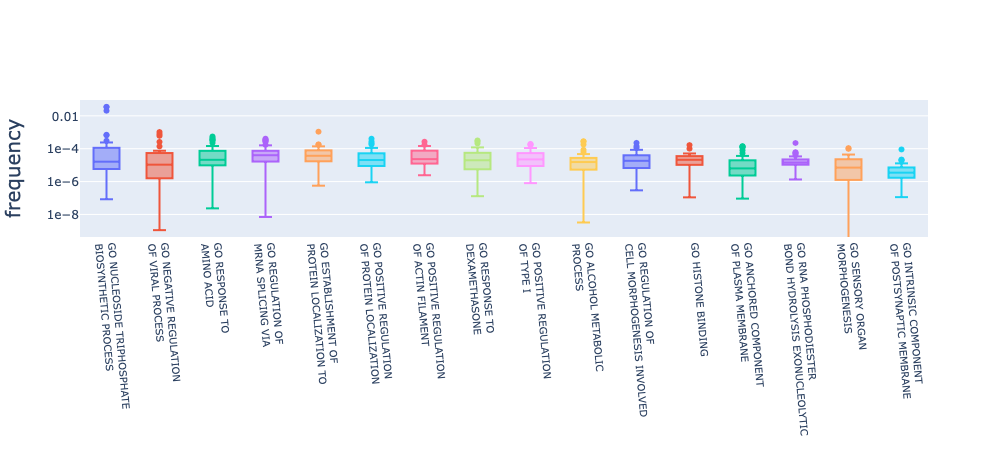

In [78]:
fig = go.Figure()

fig.add_traces(traces)

layout = {
    "yaxis":{
        "title": "frequency",
        "titlefont":{
            "size": 20
        },
        "type": "log",
        "exponentformat": "e"
    },
    "xaxis":{
      "tickfont":{
          "size": 10,
      },
        "tickangle": 85
    },
    "showlegend": False
}

fig.update_layout(layout)

fig.show()
#fig.write_image("go_plot.pdf")

In [79]:
def get_rank_plot(data):
    name, X = data
    return go.Scatter(x = np.linspace(1, len(X), len(X)), y=np.sort(data[1])[::-1]/sum(x), name=" ".join(name.split("_")[:3])+"<br>"+" ".join(name.split("_")[3:6]))

In [80]:
x = np.linspace(1,50)
traces = list(map(get_rank_plot, zip(np.array(gos_names)[mask],np.array(gos_A, dtype=object)[mask])))

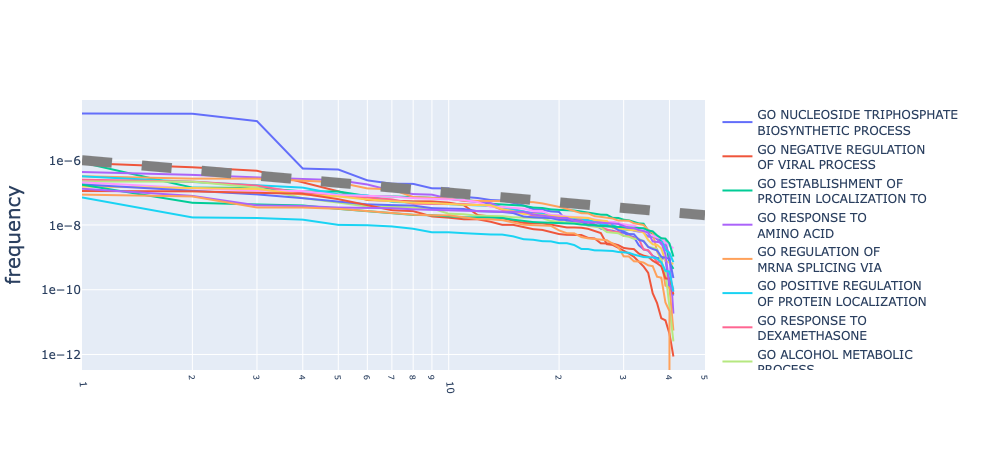

In [81]:
fig = go.Figure()

fig.add_traces(traces)
fig.add_trace(go.Scatter(x=x, y= 1e-6/x, mode="lines", line={"color":"gray","width": 10, "dash":"dash"}))

layout = {
    "yaxis":{
        "title": "frequency",
        "titlefont":{
            "size": 20
        },
        "type": "log",
        "exponentformat": "e"
    },
    "xaxis":{
         "type": "log",
      "tickfont":{
          "size": 10,
      },
        "tickangle": 85
    },
    "showlegend": True
}

fig.update_layout(layout)

fig.show()
#fig.write_image("P_g_go.pdf")

In [11]:
x = np.array(list(map(np.median, gos_A)))
y = np.array(list(map(np.std, gos_A)))
y_min = np.array(list(map(lambda x: np.quantile(x,0.25), gos_A)))
y_max = np.array(list(map(lambda x: np.quantile(x,0.75), gos_A)))

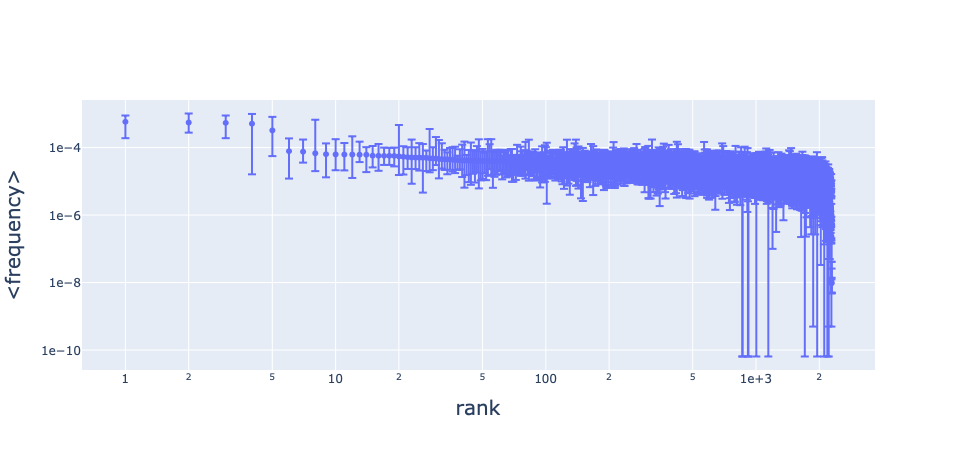

In [12]:
fig = go.Figure()

mask = np.argsort(x)[::-1]

error_y = {
    "type":"data",
    "symmetric":False,
    "array": y_max[mask]-x[mask],
    "arrayminus": x[mask]-y_min[mask]
}

#error_y = {
#    "type":"data",
#    "symmetric":True,
#    "array": y[mask]
#}

fig.add_trace(
    go.Scatter(x=np.linspace(1,1+len(x), len(x)), y=x[mask], mode = "markers", text=gos_names, error_y=error_y)
)

layout = {
    "xaxis":{
        "title": "rank",
        "titlefont":{
            "size": 20
        },
        "type": "log",
        "exponentformat": "e"
    },
    "yaxis":{
        "title": "<frequency>",
         "titlefont":{
            "size": 20
        },
        "type": "log",
        "exponentformat": "e"
    },
    "showlegend": False
}

fig.update_layout(layout)

fig.show()